# Cvičení 7 - Logistická regrese

V dnešním cvičení budeme zkoumat logistickou regresi.

## Model pro binární klasifikaci

Uvažme binární vysvětlovanou proměnnou $Y$ s hodnotami $0$ a $1$ a $p$ příznaků $X_1, X_2, \ldots, X_p$ s konstantním $X_0 = 1$.

* Namísto hodnoty vysvětlované proměnné $Y \in \{0,1\}$ se snažíme predikovat pravděpodobnost, že při zadaných hodnotách příznaků $X_i$ má $Y$ hodnotu $1$, tj. číslo $P(Y = 1 \mid \boldsymbol{x},\boldsymbol{w})$ kde $\boldsymbol{w}$ je vektor parametrů modelu.
* Pro dané hodnoty $\boldsymbol{x}^T = (x_0, x_1, \ldots, x_p)$ a koeficienty $\boldsymbol{w}^T = (w_0, w_1, \ldots, w_p)$ má model tvar
$$
P(Y = 1 \mid \boldsymbol{x},\boldsymbol{w}) = \frac{e^{\boldsymbol{w}^T \boldsymbol{x}}}{1 + e^{\boldsymbol{w}^T \boldsymbol{x}}}.
$$
* Je-li $P(Y = 1 \mid \boldsymbol{x},\boldsymbol{w})$ větší než $\frac{1}{2}$, rozhodneme se pro $Y = 1$, je-li menší než $\frac{1}{2}$, pro $Y = 0$.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Sigmoida (standardní logistická funkce)

Nejprve se podíváme na základní matematické vlastnosti sigmoidy, která je definována vztahem

$$
f(x) = \frac{e^x}{1 + e^x} = \frac{1}{1 + e^{-x}}, \qquad D_f = \mathbb{R}, \qquad H_f = (0,1).
$$

### Úkol - odvoďte si, čemu je rovna derivace sigmoidy.
Derivaci klasicky spočítejte a pak se podíváme, jak ji spočítá knihovna `sympy`.

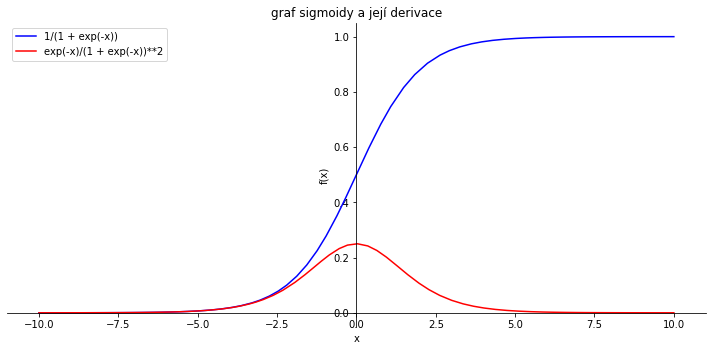

In [2]:
import sympy
x = sympy.symbols('x'); a = 10;

f = 1/(1+sympy.exp(-x)) # sigmoida
df = sympy.diff(f,x) # derivace sigmoidy

p1 = sympy.plot(f,(x,-a,a), line_color = 'b', title = 'graf sigmoidy a její derivace', legend = ['f(x)'],show = False, size = (10,5))
p2 = sympy.plot(df,(x,-a,a),line_color= 'r',legend = ['df(x)'], show = False)
p1.extend(p2)
p1.show()

Limity v $\pm \infty$:
$$ \lim_{x \to +\infty} f(x) = 1, \qquad \lim_{x \to -\infty} f(x) = 0$$

In [3]:
display(sympy.limit(f,x,sympy.oo))
display(sympy.limit(f,x,-sympy.oo))

1

0

Rovnice $f(x) = \frac{1}{2}$ má jediné řešení $x = 0$.

In [4]:
sympy.solve(f-1/2,x)

[0.0]

Derivace v $0$ je $f'(0) = \frac{1}{4}$. Rovnice tečny v bodě nula je $y = f(0) + f'(0)(x-0)=\frac{x}{4} + \frac{1}{2}$.

In [5]:
print('Rovnice tečny v bodě 0:')
display(f.subs(x,0) + df.subs(x,0)*(x))

Rovnice tečny v bodě 0:


x/4 + 1/2

## Umělá data

Pro demonstraci fungování logistické regrese si vygenerujeme umělá data se dvěma příznaky $X_0$ a $X_1$ a binární vysvětlovanou proměnnou.

Je to směs dvou dvourozměrných Gaussiánů.

In [6]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [7]:
# funkce, která připraví dataset
def get_sample(n, random_seed):
    np.random.seed(random_seed)  # zajistí replikovatelnost
    n1 = int(n/2)
    n2 = n - n1
    mean1 = [-20, 20]
    cov1 = [[3000, 850], [850, 1000]]
    mean2 = [10, -10]
    cov2 = [[3000, 850], [850, 1000]]
    X1 = np.random.multivariate_normal(mean1, cov1, n1)
    y1 = np.zeros(n1,dtype="int")
    X2 = np.random.multivariate_normal(mean2, cov2, n2)
    y2 = np.ones(n2,dtype="int")

    X = np.concatenate((X1,X2), axis=0)
    y = np.concatenate((y1,y2), axis=0)
    return X, y

# vytvoříme úvodní dataset
X, y = get_sample(300, 50)

# rozdělíme ho na trénovací a validační
from sklearn.model_selection import train_test_split
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.5, random_state = 42)

# zobrazení velikosti výsledných dat
print(Xtrain.shape)

(150, 2)


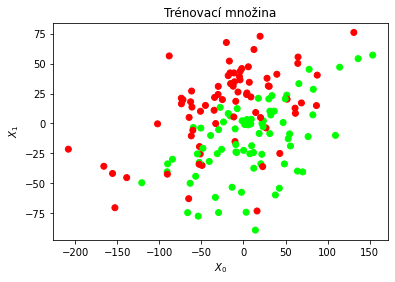

In [8]:
# Zobrazení datasetu
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, cmap=cmap_bold)
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.title("Trénovací množina")
plt.show()

## Logistická regrese 

  * Logistická regrese je v `sklearn.linear_model` jako `LogisticRegression`.
  * Používá se pak klasicky dle obvyklého API modelů v `scikit-learn`.

In [9]:
from sklearn.linear_model import LogisticRegression

clfLOG = LogisticRegression(solver='newton-cg')
clfLOG.fit(Xtrain,ytrain)
print('Koeficienty w_1 a w_2:', clfLOG.coef_)
print('Intercept w_0:', clfLOG.intercept_,"\n")

print('Klasifikace prvních 10 datových bodů z validační množiny:')
print('Predikce:', clfLOG.predict(Xval[:10,:]))
print('\nPredikce pravděpodobností:\n', clfLOG.predict_proba(Xval[:10,:]))
print('\nSkutečné labely:', yval[:10])

print('\nValidační přesnost:', clfLOG.score(Xval,yval))
print('Trénovací přesnost:', clfLOG.score(Xtrain,ytrain))

Koeficienty w_1 a w_2: [[ 0.02301739 -0.04943676]]
Intercept w_0: [0.27151165] 

Klasifikace prvních 10 datových bodů z validační množiny:
Predikce: [1 1 1 0 1 1 0 0 0 1]

Predikce pravděpodobností:
 [[0.05978628 0.94021372]
 [0.4895266  0.5104734 ]
 [0.34684194 0.65315806]
 [0.90622718 0.09377282]
 [0.03447247 0.96552753]
 [0.2378864  0.7621136 ]
 [0.51293443 0.48706557]
 [0.84977227 0.15022773]
 [0.91976888 0.08023112]
 [0.49984765 0.50015235]]

Skutečné labely: [1 1 1 0 1 1 1 0 0 1]

Validační přesnost: 0.8466666666666667
Trénovací přesnost: 0.7533333333333333


## Rozhodovací hranice logistické regrese

Z vlastností sigmoidy plyne, že rozhodovací hranice
$$
P(Y = 1 \mid \boldsymbol{x},\boldsymbol{w}) = \frac{e^{\boldsymbol{w}^T \boldsymbol{x}}}{1 + e^{\boldsymbol{w}^T \boldsymbol{x}}} = \frac{1}{2}
$$
je nadrovina
$$
\boldsymbol{w}^T \boldsymbol{x} = w_0 + w_1 x_1 + \cdots + w_p x_p = 0,
$$
v prostoru $\mathbb{R}^{p}$.

Rozhodovací hranicí je přímka $w_0 + w_1 \cdot x + w_2 \cdot y = 0$

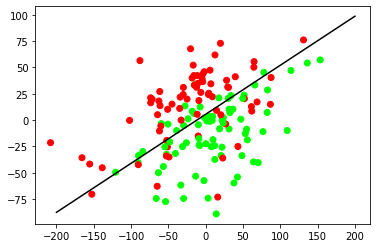

In [10]:
def fun(x, intercept, coef1, coef2):
    y = (-1/coef2)*(intercept + coef1*x)
    return y
# uděláme vektorovou funkci aby šlapala na ndarray
vfun = np.vectorize(fun)

xgrid = np.linspace(-200, 200, 200)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, cmap=cmap_bold)
plt.plot(xgrid, vfun(xgrid, clfLOG.intercept_, clfLOG.coef_[0,0], clfLOG.coef_[0,1]), 'k-')
plt.show()

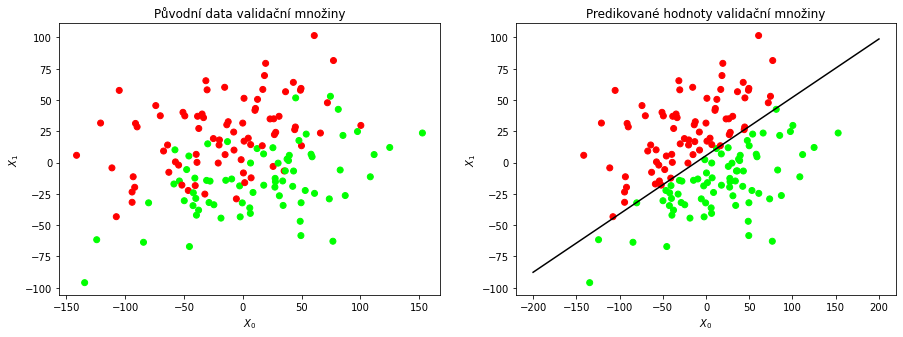

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(Xval[:, 0], Xval[:, 1], c=yval, cmap=cmap_bold);
plt.xlabel('$X_0$') 
plt.ylabel('$X_1$')
plt.title("Původní data validační množiny")
plt.subplot(122)
plt.scatter(Xval[:, 0], Xval[:, 1], c=clfLOG.predict(Xval), cmap=cmap_bold);
plt.plot(xgrid, vfun(xgrid, clfLOG.intercept_, clfLOG.coef_[0,0], clfLOG.coef_[0,1]), 'k-')
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.title("Predikované hodnoty validační množiny")
plt.show()

### Rozhodovací hranice KNN

  * Použijeme pro srovnání KNN, které známe, a ukážeme si, jak vypadá hranice, kde se mění rozhodnutí.

In [17]:
from sklearn import neighbors

h = 0.2  # step size in the mesh
n_neighbors = 5

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])

def plotkNN(weights):
    # we create an instance of Neighbours Classifier and fit the data.
    clfKNN = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clfKNN.fit(Xtrain, ytrain)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = Xtrain[:, 0].min() - 1, Xtrain[:, 0].max() + 1
    y_min, y_max = Xtrain[:, 1].min() - 1, Xtrain[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clfKNN.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(6,6))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('$X_0$')
    plt.ylabel('$X_1$')
    plt.title("2-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

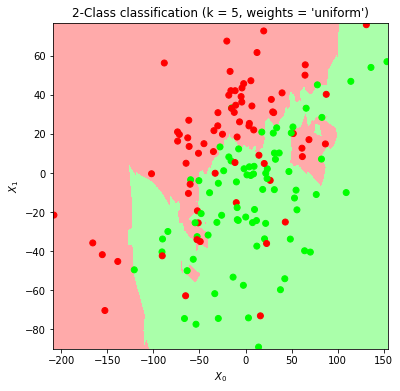

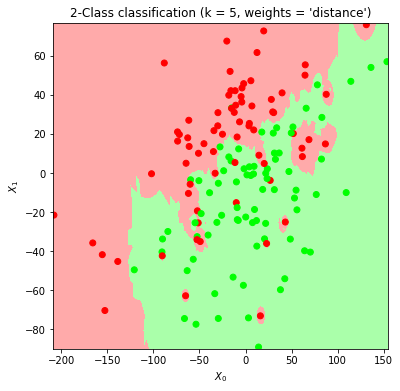

In [18]:
for weights in ['uniform', 'distance']:
    plotkNN(weights)

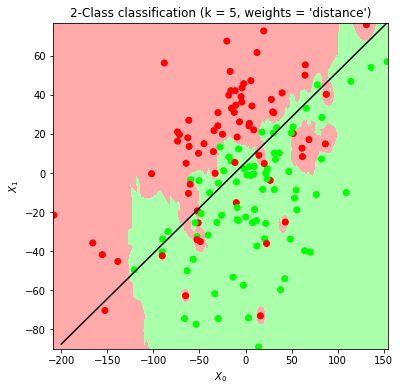

In [19]:
plotkNN('distance')
plt.plot(xgrid, vfun(xgrid, clfLOG.intercept_, clfLOG.coef_[0,0], clfLOG.coef_[0,1]), 'k-')

### Rozhodovací hranice rozhodovacího stromu

  * Pro srovnání se ještě podívejme na rozhodovací stromy

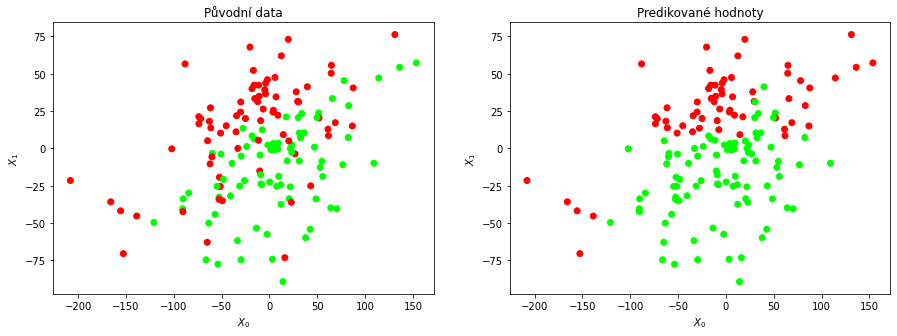

In [20]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(Xtrain, ytrain)

plt.figure(figsize=(15,5))
plt.subplot(121); plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, cmap=cmap_bold);
plt.xlabel('$X_0$'); plt.ylabel('$X_1$');
plt.title("Původní data")
plt.subplot(122); plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=dt.predict(Xtrain), cmap=cmap_bold);
plt.xlabel('$X_0$'); plt.ylabel('$X_1$')
plt.title("Predikované hodnoty")
plt.show()

## Uložení výsledného modelu

* V případě přenesení naučeného modelu do produkce či prostě při potřebě uložení výsledků práce je dobré moci si uložit výsledný model do souboru, ze kterého jej lze později načíst.
* Lze využít balíček [pickle](https://docs.python.org/3/library/pickle.html#module-pickle).
* Pro složitější struktury lze použít [joblib](https://pypi.org/project/joblib/).

In [21]:
import os, pickle # package for serializing objects in Python
filename = 'clfLOG.pickle'
pickle.dump(clfLOG, open(filename, 'wb')) # saving the model

clfLOG_loaded = pickle.load(open(filename, 'rb'))
print('Coeficients of original model:', clfLOG.coef_, clfLOG.intercept_)
print('Coefficients of loaded model:', clfLOG_loaded.coef_, clfLOG_loaded.intercept_)
print('Filesize: ', os.stat(filename).st_size, 'bytes')

Coeficients of original model: [[ 0.02301739 -0.04943676]] [0.27151165]
Coefficients of loaded model: [[ 0.02301739 -0.04943676]] [0.27151165]
Filesize:  816 bytes


## Úkol - parciální derivace a gradient

**Úkol**: Najděte gradient funkce $\ell(\boldsymbol{w})$ (viz přednášku):
$$
    \ell(\boldsymbol{w}) = \sum_{i = 1}^N \left(Y_i \ln \left( \frac{e^{\boldsymbol{w}^T \boldsymbol{x}_i}}{1 + e^{\boldsymbol{w}^T \boldsymbol{x}_i}} \right) + (1 - Y_i) \ln \left( \frac{1}{1 + e^{\boldsymbol{w}^T \boldsymbol{x}_i}} \right)\right).
$$
  * Pokuste se přepsat výsledek do maticového tvaru
  $$
  \nabla \ell(\boldsymbol{w}) = \mathbf{X}^T (\boldsymbol Y - \boldsymbol P),
  $$
  kde
  $$
\boldsymbol P = \big(p_1(\boldsymbol x_1,\boldsymbol w), \dotsc, p_1(\boldsymbol x_N,\boldsymbol w)\big)^T
$$
a
$$
p_1(\boldsymbol x_i,\boldsymbol w) = \frac{e^{\boldsymbol{w}^T \boldsymbol{x}_i}}{1 + e^{\boldsymbol{w}^T \boldsymbol{x}_i}}
$$

## Úkol - trénovaní logistické regrese gradientním sestupem

Využijte předchozího výsledku k ručnímu trénování logistické regrese. Pozor, že při metodě maximální věrohodnosti účelovou funkci (logaritmus věrohodnostní funkce) $\ell(\boldsymbol w)$ **maximalizujeme**

Využijte implementaci `scipy.special.expit` sigmoidy a poté zkuste klasický gradientní sestup, ve kterém děláte následující update: 
$$\boldsymbol w_{i+1} = \boldsymbol w_{i} + \alpha \cdot \nabla \ell(\boldsymbol{w}_i)$$
pro zvolenou learning rate $\alpha$. 

Zkuste také adaptivní verzi, při které $\alpha_i = \frac{\alpha}{1 + i}$.

V obou případech se podívejte na hodnotu výsledného gradientu a spočtěte přesnost na trénovací i validační množině. Porovnejte ji s předchozím modelem z knihovny `sklearn` (i gradient i přesnosti).

In [31]:
from scipy.special import expit

# Matice X
XX = np.matrix(np.concatenate([np.ones((Xtrain.shape[0],1)),np.array(Xtrain)], axis = 1))
XX

# Vektor Y
YY = np.matrix(ytrain).T

# gradient
def get_grad(w, XX, YY):
    PP = expit(XX*w)
    return XX.T*(YY - PP)

w_hat = np.matrix(np.ones((XX.shape[1],1)))

alpha = 0.3
for i in range(30000):
    # get gradient
    grad = get_grad(w_hat, XX, YY)
    w_hat = w_hat + alpha/(1+i)*grad

    
print('Odhad: ', w_hat.T) 
print('Gradient: ', get_grad(w_hat, XX, YY).T)

Ptrain = np.array(expit(XX*w_hat)).flatten()
Yhattrain = np.array(Ptrain > 0.5, dtype = int)

XXval = np.matrix(np.concatenate([np.ones((Xval.shape[0],1)),np.array(Xval)], axis = 1))
Pval = np.array(expit(XXval*w_hat)).flatten()
Yhatval = np.array(Pval > 0.5, dtype = int)


from sklearn.metrics import accuracy_score
print('\nTrénovací přesnost:', accuracy_score(ytrain, Yhattrain))
print('Validační přesnost:', accuracy_score(yval, Yhatval))

Odhad:  [[ 0.27178092  0.02302029 -0.04944346]]
Gradient:  [[-5.82660205e-03 -2.47097187e-05  4.93008549e-05]]

Trénovací přesnost: 0.7533333333333333
Validační přesnost: 0.8466666666666667


Podívejme se, jak je na tom model a jeho parametry z knihovny `sklearn`. Podívejme se také na velikost gradientu v tomto odhadu.

In [18]:
w_h2 = w_hat
w_h2[0,0] = clfLOG.intercept_
w_h2[1:,0] = clfLOG.coef_.T

print('Odhad: ', w_h2.T) 
print('Gradient: ', get_grad(w_h2, XX, YY).T)

Odhad:  [[ 0.27151165  0.02301739 -0.04943676]]
Gradient:  [[ 8.77120682e-10  2.30174280e-02 -4.94367967e-02]]


Trénovací a validační přesnosti pro model ze `sklearn`.

In [13]:
print('Trénovací přesnost ze sklearn:', clfLOG.score(Xtrain,ytrain))
print('Validační přesnost ze sklearn:', clfLOG.score(Xval,yval))

Trénovací přesnost ze sklearn: 0.7533333333333333
Validační přesnost ze sklearn: 0.8466666666666667
